## Setup

### Import + Utils

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from darts import TimeSeries

print("NumPy:", np.__version__)  # Should be 1.26.4
print("Pandas:", pd.__version__)  # Should be 2.2.2

NumPy: 2.2.5
Pandas: 2.2.3


In [2]:
from darts.models import Prophet, LinearRegressionModel, AutoARIMA, Theta, ExponentialSmoothing, XGBModel, FFT, NBEATSModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    InvertibleMapper,
    Mapper,
    MissingValuesFiller,
    Scaler,
    Diff
)
from darts.metrics import mape, rmse, mase, r2_score, mae
from darts import concatenate
from darts.dataprocessing.transformers import MinTReconciliator, BottomUpReconciliator, TopDownReconciliator
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pandas import Timestamp
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [5]:
from reconciliation import (
    DataLoader,
    MatrixReconciliation,
    ForecastingModels,
    Visualization,
    ModelEvaluator
)

#### Pipeline

In [6]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [42]:
global is_transformed 
is_transformed = False

In [26]:
def get_inflation(past_cov):
    #yearly global inflation data from world bank, potential extra explanatory variable for model
    inflation = pd.read_excel('globalinflation.xlsx')
    inflation = inflation.T
    inflation.index = pd.to_datetime(inflation.index, format='%Y')

    # data is yearly, make it monthly
    start_date = inflation.index.min()
    end_date = min(inflation.index.max() + pd.DateOffset(months=11),past_cov.time_index.max() )
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    inflation = inflation.reindex(date_range)
    #inflation = inflation.ffill()
    inflation = inflation.interpolate(method="linear")
    inflation = inflation.reset_index()
    inflation.columns = ["Date","inflation_rate"]

    # now can be used in past_cov
    return past_cov.stack(TimeSeries.from_dataframe(inflation, time_col="Date", value_cols="inflation_rate"))

In [38]:
def apply_transformations(series, target, operations):
    global is_transformed
    is_transformed = True
    #establish data tranformations pipeline
    #modify Pipeline()s as needed
    yeojohnson = Scaler(PowerTransformer(method='yeo-johnson'))
    robustscaler = Scaler(RobustScaler())
    firstdiff = Diff(lags=1)
    #after brief check, monthly diff is the only one that improves things, but only some models and not by much
    #yeo johnson was similar. helped some in some cases but not as much as hoped :(
    monthlydiff = Diff(lags=12)
    quarterlydiff = Diff(lags=4)
    unitransformer = Pipeline([yeojohnson])
    multitransformer = Pipeline([yeojohnson])
    #transform data, can use a more complex pipeline later using pipeline() builtin from darts
    unitransformer.fit(target)
    multitransformer.fit(series)
    target = unitransformer.transform(target)
    series = multitransformer.transform(series)
    return series, target, unitransformer, multitransformer

In [7]:
def load_data(file_path='data/SampleHierForecastingBASF_share.xlsx'):
  df = pd.read_excel(file_path)
  df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
  df = df.sort_values(by='Date')
  numeric_cols = ['EBIT', 'EBITDA', 'DepreciationAmortization', 'VariableCosts', 'NetSales', 'ContributionMargin1', 'FixCosts']
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
  return df



#log scaling too?

In [8]:
#not really confident this is performing like it should be. will look at later.
#maybe problem is fh? look at slides to pick good fh

def backtestmodels(fittedmodels, data, fh = 12, past_cov = None, retrain=True):
  backtest_results_dict = {}
  for model_name, model in fittedmodels.items():
    if model.supports_past_covariates and past_cov:
      backtested = model.historical_forecasts(
          data,
          past_covariates=past_cov,
          start=0.6,
          forecast_horizon=fh,
          stride=1,
          retrain=retrain
      )
    else:
      backtested = model.historical_forecasts(
          data,
          start=0.6,
          forecast_horizon=fh,
          stride=1,
          retrain=retrain)
    get_metrics(backtested[:-fh], data[:-fh], model_name+", Backtested")
    backtest_results_dict[model_name] = backtested
  return backtest_results_dict



In [53]:
import re
def compare_models_univariate(data, val, models, past_cov=None):
  """
    Evaluate multiple forecasting models. supports univariate and multivariate models.
    Note that this doesn't currently work with reconciliation. Do not pass data with hierarchy implemented.

    Args:
        data: Training data TimeSeries. Should consist of only target variable.
        val: Validation period time series, includes target and past_covariates
        past_covariates: Hierarchical covariates, only require

    Returns:
        Two dictionaries:
        - fitted_models: {model_name: trained_model}
        - predictions: {model_name: forecast_series}

    Example:
        >>> models = [AutoARIMA(), XGBModel(lags=12)]
        >>> fitted, preds = compare_models_simple(train, val, covariates, models)
    """
  #check performance of passed models on data, return all fitted models in case of future evaluation needs
  fittedmodels = {}
  predictions = {}
  for m in models:
    model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(m)).group(1)
    if m.supports_past_covariates and past_cov:
      m.fit(data, past_covariates=past_cov)
      pred = m.predict(n=len(val), past_covariates=past_cov)
    else:
      m.fit(data)
      pred = m.predict(n=len(val))
    fittedmodels[model_name]=m
    predictions[model_name]=pred
  get_metrics_batched(predictions, val)
  return fittedmodels, predictions

In [52]:
def compare_models_multivariate(data, val, models):
  fittedmodels = {}
  predictions = {}
  for m in models:
    model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(m)).group(1)
    m.fit(data)
    pred = m.predict(n=len(val))
    fittedmodels[model_name]=m
    predictions[model_name]=pred
  for_testing = {k:v['EBIT'] for k,v in predictions.items()}
  get_metrics_batched(for_testing, val['EBIT'])
  return fittedmodels, predictions

In [12]:
def get_metrics(pred, val, name):
  """
    Standardized performance metrics to evaluate model performance. Consider additional metrics as well.

    Args:
        pred: Predicted time series from model
        val: Validation period time series, should be same shape as pred
        name: Name of model as String

    """
  print(f"MAE for {name}: {mae(val,pred):.2f}")
  print(f"MAPE for {name}: {mape(val,pred):.2f}")
  print(f"RMSE for {name}: {rmse(val, pred):.2f}")
  print()


In [60]:
def get_metrics_batched(preds,val, listlength=3):
  """
    Standardized performance metrics to evaluate model performance. Consider adding performance evaluations accross models (ie get best performing)

    Args:
        preds: Dictionary of form name of model : predicted time series from model
        val: Validation period time series

    """
  values = {}
  #todo: add group evaluations to find best overall model
  for key in preds:
    curr_mae=mae(val,preds[key])
    print(f"MAE for {key}: {curr_mae:.2f}")
    curr_mape=mape(val,preds[key])
    print(f"MAPE for {key}: {curr_mape:.2f}")
    curr_rmse=rmse(val, preds[key])
    print(f"RMSE for {key}: {curr_rmse:.2f}")
    values[key]={'MAE': curr_mae,
                           'MAPE': curr_mape,
                           'RMSE':curr_rmse}
    print()
  sorted_models = sorted(values.items(), key=lambda x: x[1]['RMSE'])
  sorted_models = sorted_models[:listlength]
  return dict(sorted_models)


In [63]:
def compare_models_reconciliated(data, val, models, reconciliators, reconciliator_names):
  """
    Evaluate multiple multivariate forecasting models with hierarchies.
    Compare performance with and without reconciliation.
    Unreconciled predictions should perform worse than in the simple models method becuase the model doesn't know which var is target during training.

    Args:
        data: Training data TimeSeries
        val: Validation period time series
        models: a dictionary of fitted models

    Returns:
        Two dictionaries:
        - reconciled_predictions: {model_name: forecast_series}

    Example:
        >>> models = [AutoARIMA(), XGBModel(lags=12)]
        >>> fitted, preds = compare_models_simple(train, val, covariates, models)
    """
  reconciled_predictions={}
  for k,v in models.items():
    for i in range(len(reconciliators)):
      reconciled_predictions[k+", "+reconciliator_names[i]] = reconciliators[i].transform(v)
  for_testing = {k:v['EBIT'] for k,v in reconciled_predictions.items()}
  get_metrics_batched(for_testing, val['EBIT'])
  return reconciled_predictions

#### Implementing Hierarchy

In [15]:
def get_levels(ts):
  hierarchy = ts.hierarchy
  reversed = {}
  for key, value in ts.hierarchy.items():
    if value[0] in reversed:
      reversed[value[0]].append(key)
    else:
      reversed[value[0]] = [key]
  return reversed

In [16]:
def apply_hierarchy(df):
  """assumes data is in format from given sheet. change this to work with other datasets"""
  hierarchy = {
        'EBIT': ['EBITDA'],
        'DepreciationAmortization': ['EBITDA'],
        'ContributionMargin1': ['EBIT'],
        '-FixCosts': ['EBIT'],
        'NetSales': ['ContributionMargin1'],
        '-VariableCosts': ['ContributionMargin1']
    }

  if isinstance(df, pd.DataFrame):
    df['-VariableCosts'] = -df['VariableCosts']
    df['-FixCosts'] = -df['FixCosts']
    series = TimeSeries.from_dataframe(df, time_col="Date", value_cols=[
    "EBIT","EBITDA", "DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"])
    series = series.with_hierarchy(hierarchy)
    target = series["EBIT"]
    covariates = series[[
      "EBIT","EBITDA", "DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]]

  elif isinstance(df, TimeSeries):
    series = df.with_hierarchy(hierarchy)
    target = series["EBIT"]
    covariates = series[[
      "EBIT","EBITDA", "DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]]

  else:
    raise TypeError("df must be a pandas DataFrame or TimeSeries")

  return series, target, covariates

# Models

### Setup for Model Comparison

In [40]:
df = load_data()
series, target, covariates = apply_hierarchy(df)



In [41]:
#series, target, unitransformer, multitransformer = apply_transformations(series, target,[])

train, val = target[:-24], target[-24:-12]
past_cov = covariates[:-12]

In [32]:
hierarchy = {
        'EBIT': ['EBITDA'],
        'DepreciationAmortization': ['EBITDA'],
        'ContributionMargin1': ['EBIT'],
        '-FixCosts': ['EBIT'],
        'NetSales': ['ContributionMargin1'],
        '-VariableCosts': ['ContributionMargin1']
    }

#### Adding Covariates

In [27]:

#past_cov = get_inflation(past_cov)

In [ ]:
#add lag features to past_cov as well?

### Baseline Model Comparison

In [ ]:
#get baseline performance, 2022 is validation year
#don't run with covariates! it will break and you will be sad.
models_to_test = [
    #AutoARIMA(),
    AutoARIMA(),
    ExponentialSmoothing(),
    Prophet(),
    FFT(),
    #NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    #LinearRegressionModel(lags=12, lags_past_covariates=12),
    LinearRegressionModel(lags=12),
    #XGBModel(lags=12, lags_past_covariates=12),
    XGBModel(lags=12)
    ]

fittedbaselinemodels, univariate_predictions, best_models_uni = compare_models_univariate(train, val, models_to_test, past_cov)


MAE for AutoARIMA: 25446.38
RMSE for AutoARIMA: 33341.89

MAE for ExponentialSmoothing: 9987.80
RMSE for ExponentialSmoothing: 11312.62

MAE for Prophet: 12980.65
RMSE for Prophet: 16242.64

MAE for FFT: 10343.41
RMSE for FFT: 14287.85

MAE for LinearRegression: 10010.87
RMSE for LinearRegression: 12464.43

MAE for XGBRegressor: 10149.12
RMSE for XGBRegressor: 13095.70



MAE for AutoARIMA: 25446.38
MAPE for AutoARIMA: 271.66
RMSE for AutoARIMA: 33341.89

MAE for ExponentialSmoothing: 9987.80
MAPE for ExponentialSmoothing: 188.91
RMSE for ExponentialSmoothing: 11312.62

MAE for Prophet: 12980.65
MAPE for Prophet: 103.01
RMSE for Prophet: 16242.64

MAE for FFT: 10343.41
MAPE for FFT: 71.85
RMSE for FFT: 14287.85

MAE for LinearRegression: 10010.87
MAPE for LinearRegression: 225.42
RMSE for LinearRegression: 12464.43

MAE for XGBRegressor: 10149.12
MAPE for XGBRegressor: 163.96
RMSE for XGBRegressor: 13095.70



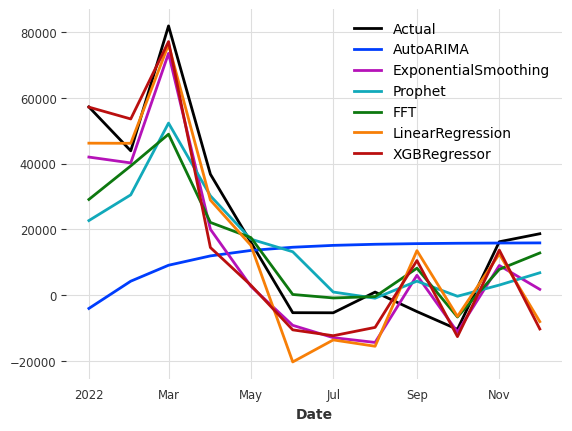

In [ ]:
if is_transformed:
    val = unitransformer.inverse_transform(val)
    #how did we perform? unscale data to find out
    val.plot(label="Actual")
    for name, forecast in univariate_predictions.items():
        temp = unitransformer.inverse_transform(forecast['EBIT'])
        temp.plot(label=name)
        get_metrics(temp, val, name)

else:
    val.plot(label="Actual")
    for name, forecast in univariate_predictions.items():
        forecast.plot(label=name)
        #get_metrics(forecast, val, name)



In [58]:
#get reconciliated performance compared to baseline multivariate, 2022 is validation year
hierarchical_train = series[:-24]
hierarchical_val = series[-24:-12]

models_to_test = [

    NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    LinearRegressionModel(lags=12),
    XGBModel(lags=12)
    ]

reconciliator0 = MinTReconciliator(method="ols")
reconciliator0.fit(series[:-24])
reconciliator1 = TopDownReconciliator()
reconciliator1.fit(series[:-24])
reconciliator2 = BottomUpReconciliator()
reconciliator3 = MatrixReconciliation(hierarchy, method='bottom_up')
reconciliator4 = MatrixReconciliation(hierarchy, method='top_down')

reconciliators = [reconciliator0,reconciliator1,reconciliator2,]
                  #reconciliator3,reconciliator4]
names = ['MiNT','Darts Top Down', 'Darts Bottom Up']
         #'Matrix Bottom Up', 'Matrix Top Down']


In [61]:
unreconciled_models, unreconciled_predictions = compare_models_multivariate(hierarchical_train, hierarchical_val, models_to_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s]
MAE for NBEATSModel: 11731.49
MAPE for NBEATSModel: 101.03
RMSE for NBEATSModel: 14489.01

MAE for LinearRegression: 10900.66
MAPE for LinearRegression: 236.56
RMSE for LinearRegression: 13185.51

MAE for XGBRegressor: 9017.24
MAPE for XGBRegressor: 145.21
RMSE for XGBRegressor: 10968.69



In [64]:
reconciliatedpredictions = compare_models_reconciliated(series[:-24], val['EBIT'], unreconciled_predictions, reconciliators, names)

MAE for NBEATSModel, MiNT: 16020.27
MAPE for NBEATSModel, MiNT: 260.48
RMSE for NBEATSModel, MiNT: 18986.95

MAE for NBEATSModel, Darts Top Down: 17566.12
MAPE for NBEATSModel, Darts Top Down: 251.31
RMSE for NBEATSModel, Darts Top Down: 20624.86

MAE for NBEATSModel, Darts Bottom Up: 26411.18
MAPE for NBEATSModel, Darts Bottom Up: 396.22
RMSE for NBEATSModel, Darts Bottom Up: 29988.78

MAE for LinearRegression, MiNT: 10900.66
MAPE for LinearRegression, MiNT: 236.56
RMSE for LinearRegression, MiNT: 13185.51

MAE for LinearRegression, Darts Top Down: 10456.90
MAPE for LinearRegression, Darts Top Down: 129.28
RMSE for LinearRegression, Darts Top Down: 13296.15

MAE for LinearRegression, Darts Bottom Up: 10900.66
MAPE for LinearRegression, Darts Bottom Up: 236.56
RMSE for LinearRegression, Darts Bottom Up: 13185.51

MAE for XGBRegressor, MiNT: 7206.94
MAPE for XGBRegressor, MiNT: 126.06
RMSE for XGBRegressor, MiNT: 9596.57

MAE for XGBRegressor, Darts Top Down: 9971.76
MAPE for XGBRegress

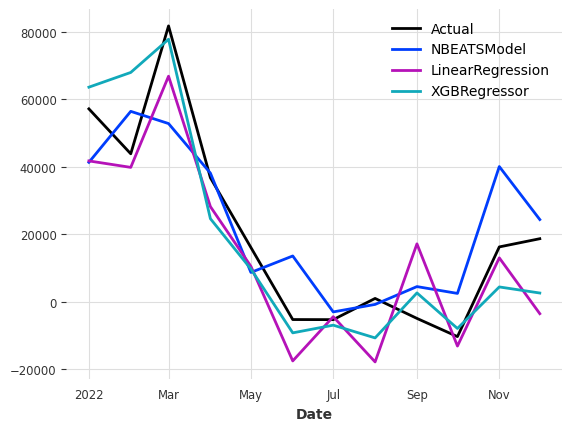

In [65]:
#how did we perform? unscale data to find out
if is_transformed:
  hierarchical_val = multitransformer.inverse_transform(hierarchical_val)
  hierarchical_val['EBIT'].plot(label="Actual")
  for k, v in reconciliatedpredictions.items():
    temp = multitransformer.inverse_transform(v)
    temp = v['EBIT']
    temp.plot(label=k)
    #get_metrics(temp, val['EBIT'], k)
else:
  hierarchical_val['EBIT'].plot(label="Actual")
  for k, v in unreconciled_predictions.items():
    v['EBIT'].plot(label=k)
    #get_metrics(v['EBIT'], val['EBIT'], k)

#wow this worsens predictions

In [ ]:
backtested = backtestmodels(fittedbaselinemodels, data = train, past_cov = past_cov, fh = 12)

### Baseline Model Comparison, Quarterly

In [ ]:
#get baseline performance, 2022 is validation year
train, val = target[:-24], series[-24:-21]

models_to_test = [
    AutoARIMA(lags=12, lags_past_covariates=12),
    ExponentialSmoothing(),
    Prophet(),
    FFT(),
    #NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    LinearRegressionModel(lags=12, lags_past_covariates=12),
    XGBModel(lags=12, lags_past_covariates=12)
    ]

fittedbaselinemodels, predictions = compare_models_simple(train, val, models_to_test, past_cov)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

MAE for AutoARIMA: 29644.25
MAPE for AutoARIMA: 49.47
RMSE for AutoARIMA: 30203.81

MAE for ExponentialSmoothing: 9075.69
MAPE for ExponentialSmoothing: 15.06
RMSE for ExponentialSmoothing: 10238.64

MAE for Prophet: 25504.54
MAPE for Prophet: 41.77
RMSE for Prophet: 27115.70

MAE for FFT: 21842.26
MAPE for FFT: 33.24
RMSE for FFT: 25094.20

MAE for LinearRegression: 17752.48
MAPE for LinearRegression: 29.31
RMSE for LinearRegression: 18215.34

MAE for XGBRegressor: 9148.86
MAPE for XGBRegressor: 17.30
RMSE for XGBRegressor: 9627.62



In [ ]:
#get reconciliated performance compared to baseline multivariate, 2022 is validation year
hierarchical_train = series[:-24]
hierarchical_val = series[-24:-21]

models_to_test = [

   # NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    LinearRegressionModel(lags=12),
    XGBModel(lags=12)
    ]

reconciliator0 = MinTReconciliator(method="ols")
reconciliator0.fit(series[:-24])

reconciliatedmodels, reconciliatedpredictions = compare_models_reconciliated(series[:-24], val['EBIT'], models_to_test, reconciliator=reconciliator0)



MAE for LinearRegression, Unreconciled: 11449.90
MAPE for LinearRegression, Unreconciled: 18.12
RMSE for LinearRegression, Unreconciled: 12597.52

MAE for LinearRegression, Reconciled: 11449.90
MAPE for LinearRegression, Reconciled: 18.12
RMSE for LinearRegression, Reconciled: 12597.52

MAE for XGBRegressor, Unreconciled: 11495.72
MAPE for XGBRegressor, Unreconciled: 23.67
RMSE for XGBRegressor, Unreconciled: 14584.08

MAE for XGBRegressor, Reconciled: 8653.99
MAPE for XGBRegressor, Reconciled: 16.62
RMSE for XGBRegressor, Reconciled: 9671.91



### Model Training (Separate Series)

In [107]:
oracle_models = {'EBIT': LinearRegressionModel(lags=12),
 'EBITDA': XGBModel(lags=12),
 'DepreciationAmortization': LinearRegressionModel(lags=12),
 'ContributionMargin1': Prophet(),
 '-FixCosts': Prophet(),
 'NetSales': LinearRegressionModel(lags=12),
 '-VariableCosts': LinearRegressionModel(lags=12)}

series_dict = {
    "EBIT": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBIT"]),
    "EBITDA": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBITDA"]),
    "DepreciationAmortization":  TimeSeries.from_dataframe(df, time_col="Date", value_cols=["DepreciationAmortization"]),
    "ContributionMargin1" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["ContributionMargin1"]),
    "-FixCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-FixCosts"]),
    "NetSales": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["NetSales"]),
    "-VariableCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-VariableCosts"]),
}


In [108]:
forecasts_dict = {}
for key in series_dict.keys():
  forecasts_dict[key] = []
  m = oracle_models[key]
  m.fit(series_dict[key][:-24])
  if m == Prophet():
    temp = m.historical_forecasts(
          series_dict[key][:-12],
          start=0.6,
          forecast_horizon=12,
          stride=1,
          retrain=True
      )
    forecasts_dict[key] =temp[-12:]
  else:
    temp = m.historical_forecasts(
          series_dict[key][:-12],
          start=0.6,
          forecast_horizon=6,
          stride=1,
          retrain=True
      )
    forecasts_dict[key] = temp[-12:]


In [ ]:
forecasts_dict['EBIT']

<TimeSeries (DataArray) (time: 12, component: 1, sample: 1)> Size: 96B
array([[[ 45554.96514217]],

       [[ 49090.18886137]],

       [[ 72863.92926955]],

       [[ 27055.03789162]],

       [[ 10774.28089797]],

       [[-20186.70910393]],

       [[-12006.22829458]],

       [[-16182.11314808]],

       [[ 14436.8171788 ]],

       [[ -7984.5435183 ]],

       [[ 14219.62768961]],

       [[ -7320.16524823]]])
Coordinates:
  * time       (time) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 8B 'EBIT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

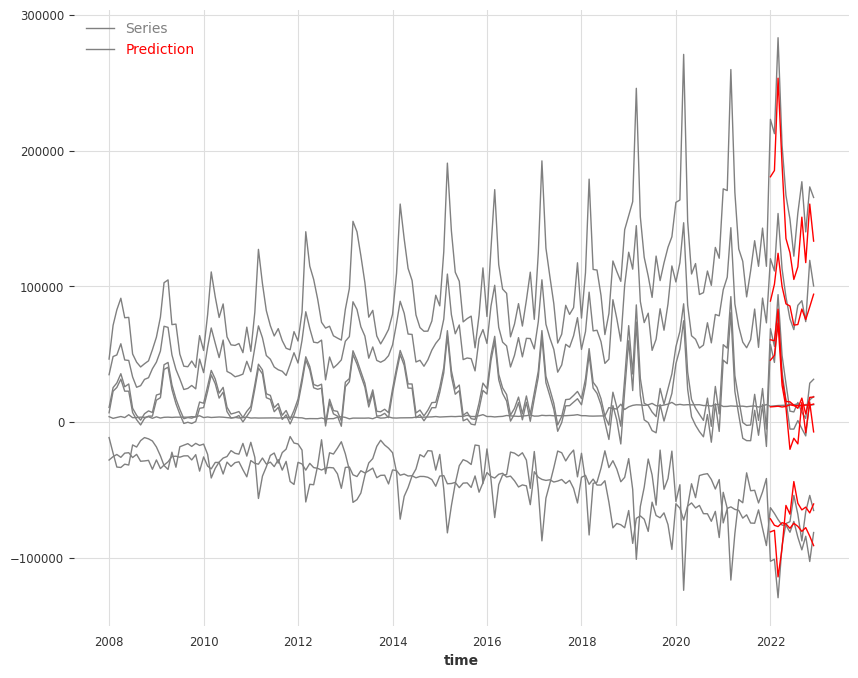

In [ ]:
#how did we do? plot to see
plt.figure(figsize=(10, 8))
#filter so we only show dates we actually calculated predictions for
filtered_series = series.drop_after(Timestamp('2022-12-31'))
filtered_series[list(forecasts_dict.keys())].plot(lw=1, color='gray', label='Actual')
for key, f in forecasts_dict.items():
    f.plot(lw=1, color='red', label=f'Predicted - {key}')  # Label with the key
plt.legend(["Series", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.show()

In [109]:
forecasts = concatenate(list(forecasts_dict.values()), axis=1)

In [ ]:
forecasts

<TimeSeries (DataArray) (time: 12, component: 7, sample: 1)> Size: 672B
array([[[  45554.96514217],
        [  60602.6953125 ],
        [  11113.11441985],
        [  89143.98286287],
        [ -71452.43994326],
        [ 180819.10677497],
        [ -81061.08366002]],

       [[  49090.18886137],
        [  59894.8125    ],
        [  11336.04992643],
        [ 101588.41265855],
        [ -76233.56490197],
        [ 185447.95524063],
        [ -79910.77602317]],

       [[  72863.92926955],
        [  83175.2734375 ],
        [  11599.40718635],
        [ 124380.92959699],
...
        [  75509.78758306],
        [ -77944.21897558],
        [ 117511.85882312],
        [ -62816.18900797]],

       [[  14219.62768961],
        [  18130.27539062],
        [  12466.2464174 ],
        [  84875.73354182],
        [ -84198.10643561],
        [ 160709.57373604],
        [ -67080.76174881]],

       [[  -7320.16524823],
        [  18397.1328125 ],
        [  13200.43177238],
        [  94196.69576814],
        [ -91195.12029838],
        [ 133377.81588866],
        [ -60493.68470238]]])
Coordinates:
  * time       (time) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 56B 'EBIT' 'EBITDA' ... '-VariableCosts'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [110]:
forecasts, temp1, temp2 = apply_hierarchy(forecasts)

In [ ]:
temp_df = ts.to_dataframe() 

temp_df = temp_df.reset_index()
temp_df.columns = ['date,'key]  # Rename the value column to the key
temp_df.head()

,time,EBITDA
0,2022-01-01,60602.695312
1,2022-02-01,59894.812500
2,2022-03-01,83175.273438
3,2022-04-01,32138.013672
4,2022-05-01,15098.332031


In [124]:
forecast_df = pd.DataFrame()
for key, ts in forecasts_dict.items():
    # Convert the TimeSeries to a DataFrame with a 'Date' index and the values in a column named after the key
    temp_df = ts.to_dataframe() 
    temp_df = temp_df.reset_index()
    temp_df.columns = ['Date',key]  # Rename the value column to the key
    # Merge the temporary DataFrame into the main DataFrame
    if forecast_df.empty:
        forecast_df = temp_df  # Initialize if empty
    else:
        forecast_df = forecast_df.merge(temp_df, on='Date', how='outer')

In [ ]:
forecasts['EBIT']

<TimeSeries (DataArray) (time: 12, component: 1, sample: 1)> Size: 96B
array([[[ 45554.96514217]],

       [[ 49090.18886137]],

       [[ 72863.92926955]],

       [[ 27055.03789162]],

       [[ 10774.28089797]],

       [[-20186.70910393]],

       [[-12006.22829458]],

       [[-16182.11314808]],

       [[ 14436.8171788 ]],

       [[ -7984.5435183 ]],

       [[ 14219.62768961]],

       [[ -7320.16524823]]])
Coordinates:
  * time       (time) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 8B 'EBIT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [125]:
reconciliator0 = MinTReconciliator(method="ols")
reconciliator0.fit(series[:-24])
reconciliator1 = TopDownReconciliator()
reconciliator1.fit(series[:-24])
reconciliator2 = BottomUpReconciliator()

In [127]:
reconciled0_forecasts = reconciliator0.transform(forecasts)
get_metrics(reconciled0_forecasts['EBIT'], val, " Model Ensemble, MiNT")
reconciled1_forecasts = reconciliator1.transform(forecasts)
get_metrics(reconciled1_forecasts['EBIT'], val, " Model Ensemble, Darts Top Down")
reconciled2_forecasts = reconciliator2.transform(forecasts)
get_metrics(reconciled2_forecasts['EBIT'], val, "Model Ensemble, Darts Bottom Up")
get_metrics(forecasts['EBIT'], val, " Model Ensemble")


MAE for  Model Ensemble, MiNT: 9909.87
MAPE for  Model Ensemble, MiNT: 162.36
RMSE for  Model Ensemble, MiNT: 11806.17

MAE for  Model Ensemble, Darts Top Down: 10709.90
MAPE for  Model Ensemble, Darts Top Down: 157.23
RMSE for  Model Ensemble, Darts Top Down: 12366.01

MAE for Model Ensemble, Darts Bottom Up: 17603.48
MAPE for Model Ensemble, Darts Bottom Up: 301.98
RMSE for Model Ensemble, Darts Bottom Up: 19483.53

MAE for  Model Ensemble: 10787.90
MAPE for  Model Ensemble: 231.92
RMSE for  Model Ensemble: 12880.89



In [132]:
import matplotlib.dates as mdates

In [134]:
unreconciled_predictions.keys()

dict_keys(['NBEATSModel', 'LinearRegression', 'XGBRegressor'])

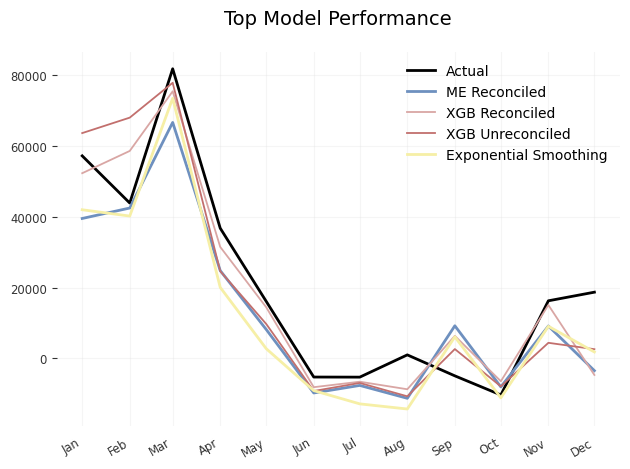

In [148]:
ax = hierarchical_val['EBIT'].plot(label="Actual")
# forecasts_dict['EBIT'].plot(label="ME Unreconciled", color='#aab8d0', ax=ax)
reconciled0_forecasts['EBIT'].plot(label="ME Reconciled", color='#6e90bf', ax=ax)
xgb_unreconciled=unreconciled_predictions['XGBRegressor'].to_dataframe()
xgb_reconciled = reconciliatedpredictions['XGBRegressor, MiNT'].to_dataframe()
xgb_reconciled['EBIT'].plot(label="XGB Reconciled", color='#D9A6A4', ax=ax)
xgb_unreconciled['EBIT'].plot(label="XGB Unreconciled", color='#C26F6D', ax=ax)
ETS=univariate_predictions['ExponentialSmoothing']
ETS.plot(label="Exponential Smoothing", color='#F6EFA6',ax=ax)


# Set x-axis as proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Month abbreviations

# Customize appearance
ax.set_title("Top Model Performance", pad=20, fontsize=14)
ax.set_xlabel("")  # Remove x-axis label
ax.grid(True, alpha=0.3)

# Add legend inside plot
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
reconciled0_forecasts = reconciliator0.transform(forecasts)
get_metrics(reconciled0_forecasts['EBIT'], val, "MiNT, XGBoost")
reconciled1_forecasts = reconciliator1.transform(forecasts)
get_metrics(reconciled1_forecasts['EBIT'], val, "TopDown, XGBoost")
reconciled2_forecasts = reconciliator2.transform(forecasts)
get_metrics(reconciled2_forecasts['EBIT'], val, "BottomUp, XGBoost")

get_metrics(forecasts['EBIT'], val, "Unreconciled, XGBoost")

MAE for MiNT, Forecasts Predicted Separately, Target Variable: 9674.72
MAPE for MiNT, Forecasts Predicted Separately, Target Variable: 169.48
RMSE for MiNT, Forecasts Predicted Separately, Target Variable: 11806.31

MAE for TopDown, Forecasts Predicted Separately: 11765.18
MAPE for TopDown, Forecasts Predicted Separately: 136.54
RMSE for TopDown, Forecasts Predicted Separately: 13174.06

MAE for BottomUp, Forecasts Predicted Separately, Target Variable: 17861.14
MAPE for BottomUp, Forecasts Predicted Separately, Target Variable: 306.97
RMSE for BottomUp, Forecasts Predicted Separately, Target Variable: 19645.02

MAE for Unreconciled, Forecasts Predicted Separately, Target Variable: 10010.87
MAPE for Unreconciled, Forecasts Predicted Separately, Target Variable: 225.42
RMSE for Unreconciled, Forecasts Predicted Separately, Target Variable: 12464.43



#### Backtesting

In [ ]:
#now the version using separately trained time series AND backtesting
#todo: compare models for each covariate to find the best one


# Assuming forecasts_dict holds your individual forecasts (key: component, value: TimeSeries)
backtest_results_dict = {}  # Dictionary to store individual component backtests

# Loop 1: Backtesting with Exponential Smoorhing for EBIT and EBITDA
for key in ["EBIT", "EBITDA"]:
    model = AutoARIMA(lags=12)  # Assuming AutoARIMA for these components
    model.fit(series_dict[key][:-12])  # Fit to training data
    backtest_results_dict[key] = model.historical_forecasts(
        series_dict[key][:-12],
        start=0.6,
        forecast_horizon=6,
        stride=1,
        retrain=True
    )

# Loop 2: Backtesting with Linear Regression for other series
for key in forecasts_dict.keys():
    if key not in ["EBIT", "EBITDA"]:  # Exclude EBIT and EBITDA
        model = LinearRegressionModel(lags=3)  # Assuming Linear Regression
        model.fit(series_dict[key][:-12])  # Fit to training data
        backtest_results_dict[key] = model.historical_forecasts(
            series_dict[key][:-12],
            start=0.6,
            forecast_horizon=3,
            stride=1,
            retrain=True
        )
# Combine the individual backtest results into a single TimeSeries
backtest_results = concatenate(list(backtest_results_dict.values()), axis=1)


Streaming output truncated to the last 5000 lines.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

ValueError: The keys of the hierarchy must be time series components

In [ ]:
# Add the hierarchy to backtest_results (if you need it for reconciliation)
backtest_results = backtest_results.with_hierarchy(hierarchy)

# Now apply your reconciliation method (like BottomUpReconciliator)
reconciled_backtest_results = reconciliator1.transform(backtest_results)


In [ ]:
# prompt: evaluate prediction performance across hierarchy levels

def evaluate_prediction_performance_hierarchy(pred, val, hierarchy):
  """
  Evaluates prediction performance across different levels of a hierarchy.

  Args:
      pred: TimeSeries object with predictions.
      val: TimeSeries object with actual values.
      hierarchy: Dictionary representing the hierarchy of components.
  """

  # Evaluate overall performance
  calculate_metrics_for_level(pred, val, "Overall")


  # Iterate through hierarchy levels
  for level_name, components in hierarchy.items():
      pred_level = pred.filter(level_name)
      val_level = val.filter(level_name)
      print(level_name)
      get_metrics(pred_level, val_level, level_name)


# Example usage:
# Assuming you have pred and val as TimeSeries objects and hierarchy defined as above
evaluate_prediction_performance_hierarchy(pred, val, hierarchy)


NameError: name 'pred' is not defined

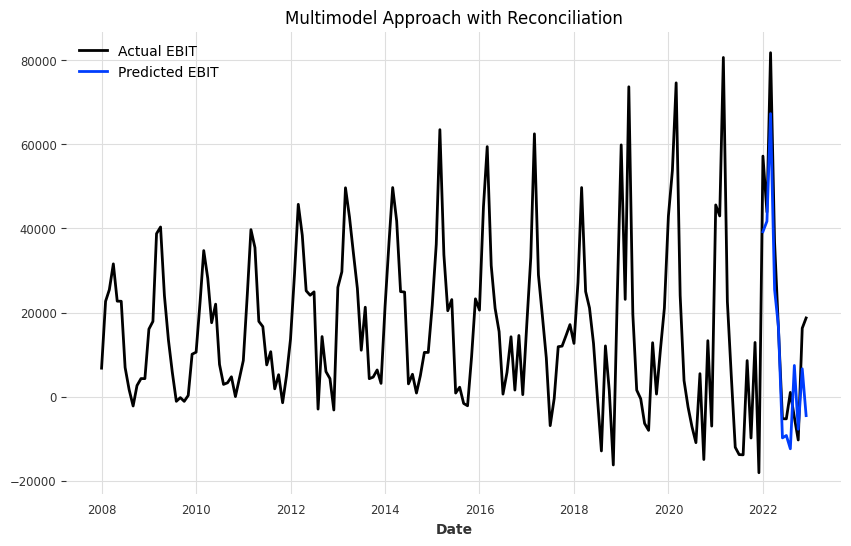

In [ ]:
plt.figure(figsize=(10, 6))
filtered_series["EBIT"].plot(label="Actual EBIT")
reconciled0_forecasts['EBIT'].plot(label="Predicted EBIT")
plt.legend()
plt.title("Multimodel Approach with Reconciliation")
plt.show()


In [ ]:
get_metrics(backtest_results, val, "Multi Model with Backtest, Unreconciled")
print()
get_metrics(reconciled_backtest_results, val, "Multi Model with Backtest, Reconciled")
reconciled_backtest_results_multimodel = reconciled_backtest_results

# Reconciliation Investigation

<Figure size 1000x500 with 0 Axes>

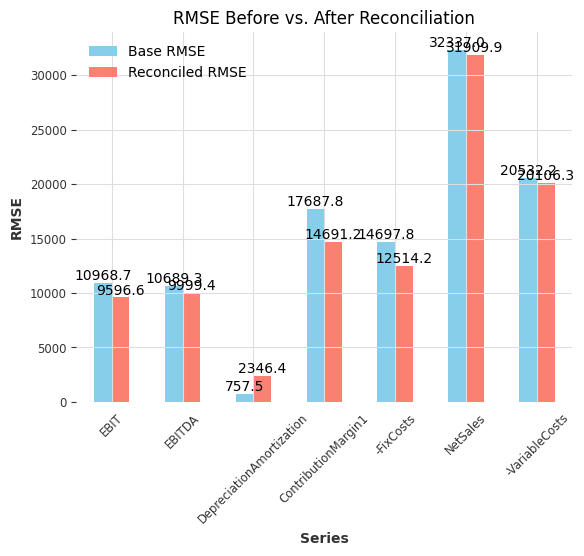

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual errors)

cols = xgb_preds.columns
base_rmse = [rmse(xgb_preds[s], hierarchical_val[s]) for s in cols]
reconciled_rmse = [rmse(reconciled0_preds[s], hierarchical_val[s]) for s in cols]

plot_df = pd.DataFrame({"Series": cols, "Base RMSE": base_rmse, "Reconciled RMSE": reconciled_rmse})

plt.figure(figsize=(10, 5))
ax = plot_df.plot(x="Series", y=["Base RMSE", "Reconciled RMSE"], kind="bar", color=["skyblue", "salmon"])
plt.title("RMSE Before vs. After Reconciliation")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

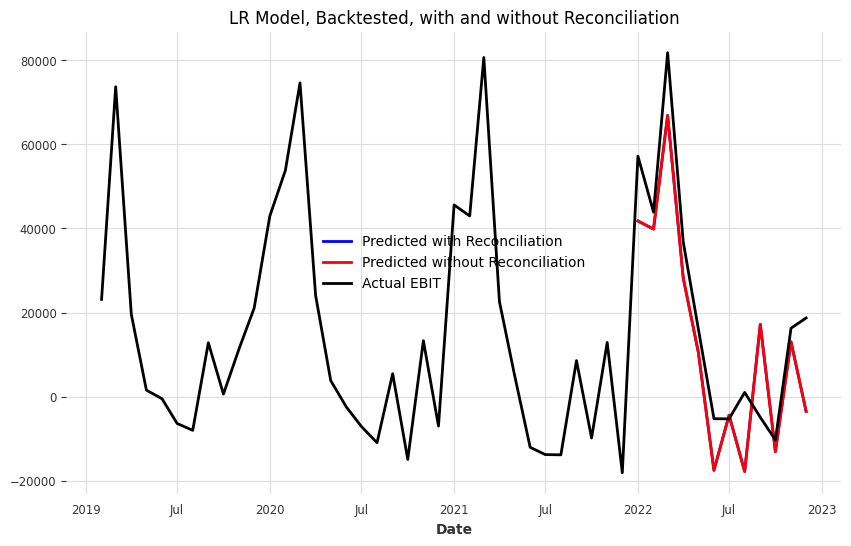

In [ ]:
plt.figure(figsize=(10, 6))
reconciledlr_preds["EBIT"].plot(label="Predicted with Reconciliation", color="blue")
lr_preds["EBIT"].plot(label="Predicted without Reconciliation", color="red")
series.drop_before(Timestamp('2019-01-01')).drop_after((Timestamp('2023-01-01')))["EBIT"].plot(label="Actual EBIT", color="black")


plt.legend()
plt.title("LR Model, Backtested, with and without Reconciliation")
plt.show()

# Kat Experiments

### Hierarchical Structure analysis

In [ ]:
# 1. Check ACTUAL DATA hierarchy violations
def check_hierarchy(actuals: pd.DataFrame):
    if 'FixCosts' in actuals.columns:
      violations = {
          'EBITDA_EBIT_Dep': actuals['EBITDA'] - (actuals['EBIT'] + actuals['DepreciationAmortization']),
          'EBIT_CM_FixCosts': actuals['EBIT'] - (actuals['ContributionMargin1'] - actuals['FixCosts']),
          'CM_Sales_VarCosts': actuals['ContributionMargin1'] - (actuals['NetSales'] - actuals['VariableCosts'])
      }
    else:
      violations = {
          'EBITDA_EBIT_Dep': actuals['EBITDA'] - (actuals['EBIT'] + actuals['DepreciationAmortization']),
          'EBIT_CM_FixCosts': actuals['EBIT'] - (actuals['ContributionMargin1'] + actuals['-FixCosts']),
          'CM_Sales_VarCosts': actuals['ContributionMargin1'] - (actuals['NetSales'] + actuals['-VariableCosts'])
      }

    return pd.DataFrame(violations)

# 2. Check FORECAST hierarchy violations
def check_forecast_violations(forecasts: pd.DataFrame):
    return check_hierarchy(forecasts)  # Same logic as above

# 3. Anti-Reconciliation Test (Run this after reconciliation)
def anti_reconciliation_test(base_forecasts, reconciled_forecasts, actuals):
    results = {}
    for col in actuals.columns:
        base_error = np.mean(np.abs(base_forecasts[col] - actuals[col]))
        recon_error = np.mean(np.abs(reconciled_forecasts[col] - actuals[col]))
        results[col] = {'BaseError': base_error, 'ReconError': recon_error, 'Worsened': recon_error > base_error}
    return pd.DataFrame(results).T

In [ ]:
shortened = df[df['Date'] <= Timestamp('2022-12-31')]

In [ ]:
check_hierarchy(shortened).head()

,EBITDA_EBIT_Dep,EBIT_CM_FixCosts,CM_Sales_VarCosts
0,0.000000e+00,3.637979e-12,0.0
1,3.637979e-12,0.000000e+00,0.0
2,-3.637979e-12,3.637979e-12,0.0
3,0.000000e+00,-3.637979e-12,0.0
4,-3.637979e-12,0.000000e+00,0.0


In [ ]:
check_hierarchy(forecast_df).head()

,EBITDA_EBIT_Dep,EBIT_CM_FixCosts,CM_Sales_VarCosts
Date,,,
2022-01-01,1724.175938,28482.217868,-7793.346675
2022-02-01,3591.326152,20356.191855,-5322.312137
2022-03-01,-7941.828658,28505.902807,-12497.843078
2022-04-01,-9684.461952,3478.825529,1394.692181
2022-05-01,15090.052410,3358.349048,12871.609294


#### Forecast Window/Hyperparameter Tests

In [ ]:
!pip install "optuna<4.0.0" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.0 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.pruners import MedianPruner

def objective(trial):
    params = {
        'input_chunk_length': trial.suggest_categorical('input_chunk_length', [12, 24, 36]),
        'output_chunk_length': trial.suggest_categorical('output_chunk_length', [6, 12, 24]),
        'dropout': trial.suggest_float('dropout', 0.0, 0.3),
        'n_epochs': trial.suggest_int('n_epochs', 10, 50),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
    }

    model = NBEATSModel(**params,
                        pl_trainer_kwargs={
            'enable_progress_bar': False  # Reduce output clutter
        })

    try:
        model.fit(
            train,
            past_covariates=past_cov,
            epochs=params['n_epochs'],
            verbose=False
        )

        # Report intermediate score (enables pruning)
        pred = model.predict(len(val))
        mape_score = mape(val['EBIT'], pred)
        trial.report(mape_score, step=model.epochs_trained)

        # Handle pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

        return mape_score

    except Exception as e:
        print(f"Trial failed: {str(e)}")
        raise optuna.TrialPruned()



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
#Best params: {'input_chunk_length': 36, 'output_chunk_length': 24, 'dropout': 0.11891699976631348, 'n_epochs': 27, 'batch_size': 128}

[I 2025-04-02 19:43:24,199] A new study created in memory with name: no-name-f18e523f-1478-4fd5-bb49-22ac2e840bb6
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=33` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:43:49,680] Trial 0 finished with value: 93.34948243119568 and parameters: {'input_chunk_length': 12, 'output_chunk_length': 24, 'dropout': 0.04236359886546693, 'n_epochs': 33, 'batch_size': 64}. Best is trial 0 with value: 93.34948243119568.
INFO:pytorch_lightning.utilities.rank_zero:GPU available

Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:46:59,712] Trial 6 finished with value: 156.85003135096343 and parameters: {'input_chunk_length': 24, 'output_chunk_length': 12, 'dropout': 0.1990734567807394, 'n_epochs': 25, 'batch_size': 64}. Best is trial 0 with value: 93.34948243119568.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
IN

Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=38` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:47:56,963] Trial 8 pruned. 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=47` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:48:24,981] Trial 9 pruned. 


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:48:36,169] Trial 10 finished with value: 156.85155107348612 and parameters: {'input_chunk_length': 12, 'output_chunk_length': 24, 'dropout': 0.13507367444690055, 'n_epochs': 10, 'batch_size': 32}. Best is trial 0 with value: 93.34948243119568.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:py

Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=34` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:49:45,135] Trial 14 finished with value: 155.33853104784887 and parameters: {'input_chunk_length': 36, 'output_chunk_length': 24, 'dropout': 0.2330469626507527, 'n_epochs': 34, 'batch_size': 32}. Best is trial 12 with value: 75.33324705577773.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=31` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:50:17,801] Trial 16 finished with value: 97.50619279706872 and parameters: {'input_chunk_length': 12, 'output_chunk_length': 24, 'dropout': 0.24803150314304637, 'n_epochs': 31, 'batch_size': 128}. Best is trial 12 with value: 75.33324705577773.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=14` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False

Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=29` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:51:31,477] Trial 22 pruned. 


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:51:57,326] Trial 23 pruned. 


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=33` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:52:13,305] Trial 24 pruned. 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=38` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:52:42,734] Trial 25 finished with value: 120.08425746702186 and parameters: {'input_chunk_length': 12, 'output_chunk_length': 24, 'dropout': 0.16062801430920093, 'n_epochs': 38, 'batch_size': 64}. Best is trial 18 with value: 73.51256927397804.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=28` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False

Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:53:25,420] Trial 28 pruned. 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trial failed: 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
[I 2025-04-02 19:53:41,774] Trial 29 pruned. 


Trial failed: 
Best params: {'input_chunk_length': 36, 'output_chunk_length': 24, 'dropout': 0.11891699976631348, 'n_epochs': 27, 'batch_size': 128}


In [ ]:
#]what is the best forecasting model for regression model?
for i in [1,3,6,12]:
  backtest_results = model.historical_forecasts(
      series[:-12],
      #past_covariates=past_cov,
      start=0.6,  # Start backtesting after 60% of the dataset
      forecast_horizon=i,
      stride=1,  # Move forward one step at a time
      retrain=True,  # Retrain after each forecast
  )
  get_metrics(backtest_results, val, "LR with Backtest, forecast horizon "+str(i))
  print()

#answer appears to be 3


MAE for LR with Backtest, forecast horizon 1: 9872.47
MAPE for LR with Backtest, forecast horizon 1: 45.39
RMSE for LR with Backtest, forecast horizon 1: 11778.32



MAE for LR with Backtest, forecast horizon 3: 9123.38
MAPE for LR with Backtest, forecast horizon 3: 49.40
RMSE for LR with Backtest, forecast horizon 3: 10933.19



MAE for LR with Backtest, forecast horizon 6: 10843.11
MAPE for LR with Backtest, forecast horizon 6: 61.07
RMSE for LR with Backtest, forecast horizon 6: 12646.27

MAE for LR with Backtest, forecast horizon 12: 11848.74
MAPE for LR with Backtest, forecast horizon 12: 53.95
RMSE for LR with Backtest, forecast horizon 12: 13904.54



In [ ]:
#best forecast horizon for ExponentialSmoothing and Prophet
for i in [6,12,24,36]:
  backtest_results = ExponentialSmoothing().historical_forecasts(
      series['EBIT'][:-12],
      #past_covariates=past_cov,
      start=0.6,  # Start backtesting after 60% of the dataset
      forecast_horizon=i,
      stride=1,  # Move forward one step at a time
      retrain=True,  # Retrain after each forecast
  )
  get_metrics(backtest_results, val['EBIT'], "Exponential Smoothing, forecast horizon "+str(i))
  print()

#best forecast_horizon found to be 12 or 24

#for i in [1,3,6,12]:
 # backtest_results = Prophet().historical_forecasts(
  #    series['EBIT'][:-12],
      #past_covariates=past_cov,
   #   start=0.6,  # Start backtesting after 60% of the dataset
    #  forecast_horizon=i,
     # stride=1,  # Move forward one step at a time
      #retrain=True,  # Retrain after each forecast
  #)
  #get_metrics(backtest_results, val['EBIT'], "Prophet, forecast horizon "+str(i))
  #print()

#12 or 24 months best

MAE for Exponential Smoothing, forecast horizon 6: 10340.07
MAPE for Exponential Smoothing, forecast horizon 6: 185.03
RMSE for Exponential Smoothing, forecast horizon 6: 12438.13

MAE for Exponential Smoothing, forecast horizon 12: 9104.62
MAPE for Exponential Smoothing, forecast horizon 12: 156.10
RMSE for Exponential Smoothing, forecast horizon 12: 10503.56

MAE for Exponential Smoothing, forecast horizon 24: 10329.00
MAPE for Exponential Smoothing, forecast horizon 24: 120.36
RMSE for Exponential Smoothing, forecast horizon 24: 12026.11

MAE for Exponential Smoothing, forecast horizon 36: 11964.15
MAPE for Exponential Smoothing, forecast horizon 36: 147.62
RMSE for Exponential Smoothing, forecast horizon 36: 15405.46



### best models per series

In [ ]:
import re
models_to_test = [
    AutoARIMA(lags=12),
    #ExponentialSmoothing(),
    Prophet(),
    FFT(),
    LinearRegressionModel(lags=12),
    XGBModel(lags=12)
    ]


series_dict = {
    "EBIT": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBIT"]),
    "EBITDA": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBITDA"]),
    "DepreciationAmortization":  TimeSeries.from_dataframe(df, time_col="Date", value_cols=["DepreciationAmortization"]),
    "ContributionMargin1" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["ContributionMargin1"]),
    "-FixCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-FixCosts"]),
    "NetSales": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["NetSales"]),
    "-VariableCosts" : TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-VariableCosts"]),
}


# Train models separately for each series
forecasts_dict = {}
for key in series_dict.keys():
  forecasts_dict[key] = []
  for model in models_to_test:
    print(model)
    model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(model)).group(1)
    model.fit(series_dict[key][:-24])
    forecasts_dict[key].append({model_name:model.predict(n=len(val))})

#forecasts = concatenate(list(forecasts_dict.values()), axis=1)

AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
AutoARIMA(lags=12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prophet()
FFT()
LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [ ]:
best_models_rmse = {}
best_models_mae = {}
best_models_mape = {}
for s in series_dict.keys():
  print(s)
  print("processing... ")
  #get best performing model
  v = series_dict[s][-24:-12]
  current = forecasts_dict[s]
  best_rmse = float('inf')
  best_mae = float('inf')
  best_mape = float('inf')
  for model_data in current:
    for name, f in model_data.items():
      if rmse(v,f) < best_rmse:
        best_models_rmse[s] = name
        best_rmse = rmse(v,f)
      if mae(v,f) < best_mae:
        best_models_mae[s] = name
        best_mae = mae(v,f)
      if mape(v,f) < best_mape:
        best_models_mape[s] = name
        best_mape = mape(v,f)


EBIT
processing... 
EBITDA
processing... 
DepreciationAmortization
processing... 
ContributionMargin1
processing... 
-FixCosts
processing... 
NetSales
processing... 
-VariableCosts
processing... 


In [ ]:
# prompt: select most frequent string from list

from collections import Counter

def most_frequent_string(string_list):
  """
  Finds the most frequent string in a list of strings.

  Args:
    string_list: A list of strings.

  Returns:
    The most frequent string in the list. Returns None if the list is empty.
  """
  if not string_list:
    return None

  string_counts = Counter(string_list)
  return string_counts.most_common(1)[0][0]


In [ ]:
best_overall_models = {}
for s in best_models_rmse.keys():
  if best_models_mae[s] == best_models_mape[s]:
    best_overall_models[s] = best_models_mape[s]
  else:
    best_overall_models[s] = best_models_rmse[s]

In [ ]:
best_overall_models

{'EBIT': 'LinearRegression',
 'EBITDA': 'XGBRegressor',
 'DepreciationAmortization': 'LinearRegression',
 'ContributionMargin1': 'Prophet',
 '-FixCosts': 'Prophet',
 'NetSales': 'LinearRegression',
 '-VariableCosts': 'LinearRegression'}

## Time Series Decomposition

https://medium.com/@heyamit10/time-series-decomposition-in-python-049b72a00ba0

https://www.kaggle.com/code/bextuychiev/advanced-time-series-analysis-decomposition


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

Level: The average value in the series.

Trend: The increasing or decreasing value in the series.

Seasonality: The repeating short-term cycle in the series.

Noise (Residual) : The random variation in the series. What’s left after you strip away the trend and seasonality — the random noise.


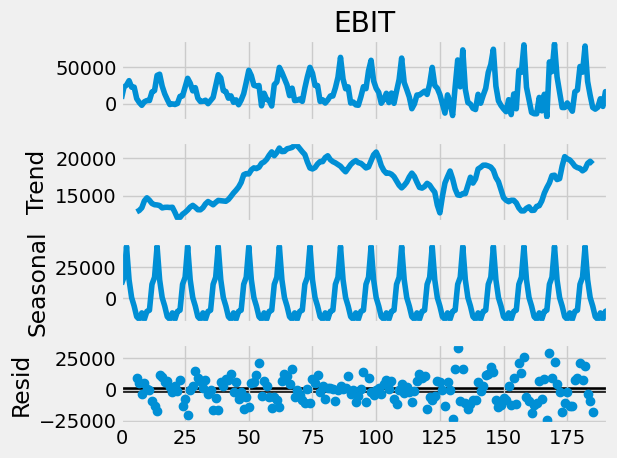

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series (assume an additive model)
result = seasonal_decompose(df['EBIT'], model='additive', period=12)
# Plot the decomposition
result.plot()
plt.show()

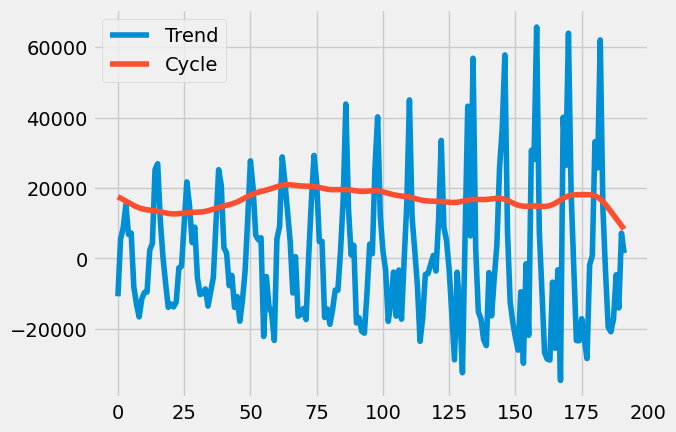

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter
# Apply the Hodrick-Prescott filter
trend, cycle = hpfilter(df['EBIT'], lamb=1600)  # 'lamb' is the smoothing parameter
# Plot the trend and cycle components
plt.plot(trend, label='Trend')
plt.plot(cycle, label='Cycle')
plt.legend()
plt.show()

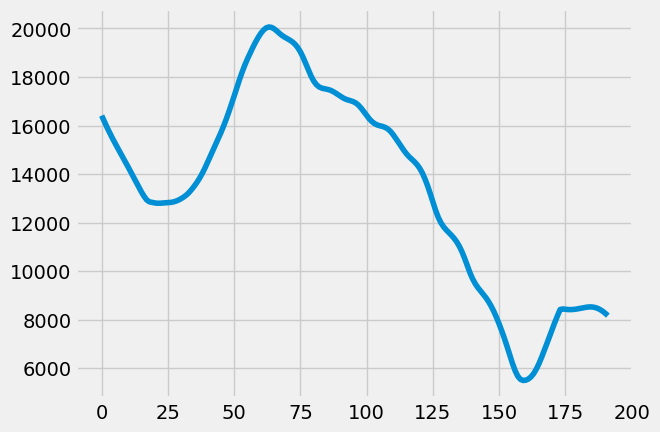

In [ ]:
import statsmodels.api as sm
# Apply LOESS smoothing
loess = sm.nonparametric.lowess(df['EBIT'], df.index, frac=0.2)
# Plot the smoothed line
plt.plot(df.index, loess[:, 1], label='LOESS Smoothed')
plt.show()

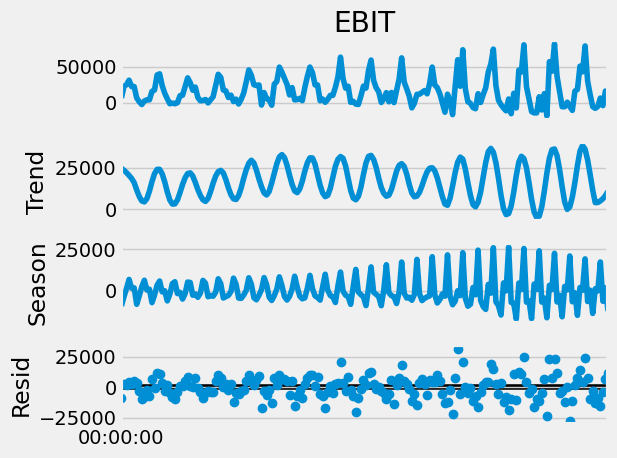

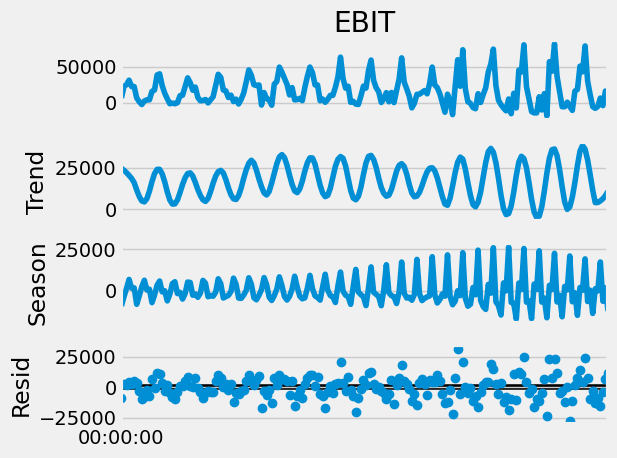

In [ ]:
from statsmodels.tsa.seasonal import STL

df.index = pd.to_datetime(df.index)
# Apply STL decomposition
stl = STL(df['EBIT'], seasonal=13, period=6)  # Ensure period is set
result = stl.fit()
result.plot()

In [ ]:
# Load the data and adjust negative values as needed
df = pd.read_excel(file_path)
df["-DepreciationAmortization"] = -df["DepreciationAmortization"]
df["-FixCosts"] = -df["FixCosts"]
df["-VariableCosts"] = -df["VariableCosts"]

# Create a dictionary of TimeSeries for each variable
series_dict = {
    "EBIT": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBIT"]),
    "EBITDA": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["EBITDA"]),
    "-DepreciationAmortization": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-DepreciationAmortization"]),
    "ContributionMargin1": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["ContributionMargin1"]),
    "-FixCosts": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-FixCosts"]),
    "NetSales": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["NetSales"]),
    "-VariableCosts": TimeSeries.from_dataframe(df, time_col="Date", value_cols=["-VariableCosts"]),
}

# Train models separately for each series and forecast
forecasts_dict = {}
for key, ts in series_dict.items():
    # Split each series into training and validation segments
    train, val = ts[:-24], ts[-24:-12]

    # Choose the model based on the key
    if key in ["EBIT", "EBITDA"]:
        model = AutoARIMA(lags=12)
    else:
        model = LinearRegressionModel(lags=12)

    # Fit the model, explicitly passing future_covariates (None if not used)
    model.fit(train, future_covariates=None)

    # Predict for the length of the validation period, also passing future_covariates=None
    forecast = model.predict(n=len(val), future_covariates=None)
    forecasts_dict[key] = forecast

# Combine all forecasts into a multivariate TimeSeries (each column corresponds to one variable)
forecasts = concatenate(list(forecasts_dict.values()), axis=1)

In [ ]:
components_to_show = ["EBIT","EBITDA", "DepreciationAmortization", "ContributionMargin1", "FixCosts", "NetSales", "VariableCosts"]
plt.figure(figsize=(10, 8))

# Create a multivariate TimeSeries using all desired columns
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=components_to_show)
pred[components_to_show].plot(lw=1, color='red')
plt.legend(["Series", "Prediction"], loc="upper left")
plt.show()

In [ ]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

In [ ]:
# Define hierarchical levels
level_1 = ["EBIT"]  # Top-level
level_2 = ["ContributionMargin1", "-FixCosts"]
level_3 = ["EBITDA", "-DepreciationAmortization"]
level_4 = ["NetSales", "-VariableCosts","-FixCosts"]
# Define a function to measure MAE
def measure_mae(pred, val):
    def print_mae_on_subset(subset, name):
        mae_value = mae(pred[subset], val[subset])
        print(f"mean MAE on {name}: {mae_value:.2f}")

    # Measure MAE at each hierarchical level
    print_mae_on_subset(level_1, "Level 1 (Top-Level: EBIT)")
    print_mae_on_subset(level_2, "Level 2 Components)")
    print_mae_on_subset(level_3, "Level 3 Components)")
    print_mae_on_subset(level_3, "Level 4 Components)")

# Call the function
measure_mae(pred, val)


get_metrics(forecast_test, test_series, 'LR')

mean MAE on Level 1 (Top-Level: EBIT): 10900.66
mean MAE on Level 2 Components): 8287.28
mean MAE on Level 3 Components): 5940.98
mean MAE on Level 4 Components): 5940.98


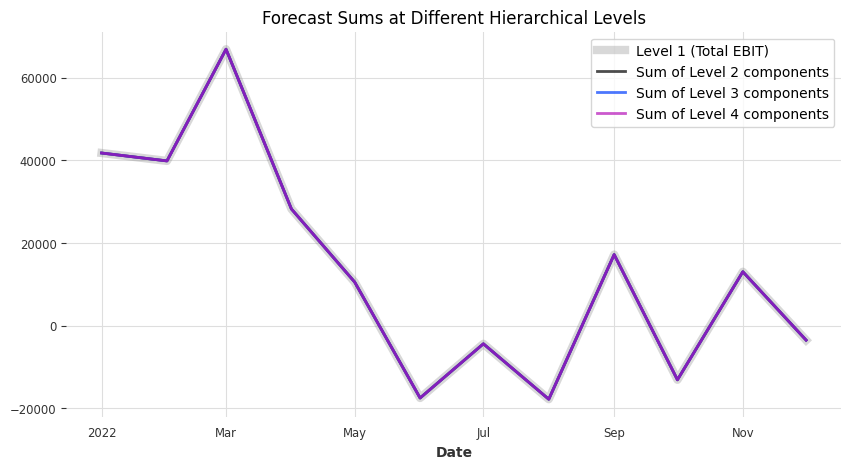

In [ ]:
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 5))

    # Define levels in the hierarchy
    level_1 = ["EBIT"]  # Top-level
    level_2 = ["ContributionMargin1", "-FixCosts"]
    level_3 = ["EBITDA", "-DepreciationAmortization"]
    level_4 = ["NetSales", "-VariableCosts","-FixCosts"]

    # Plot the top-level component (EBIT)
    pred_series[level_1].sum(axis=1).plot(
        label="Level 1 (Total EBIT)", lw=6, alpha=0.3, color="grey"
    )
    pred_series[level_2].sum(axis=1).plot(label="Sum of Level 2 components",alpha = 0.7)
    pred_series[level_3].sum(axis=1).plot(label="Sum of Level 3 components",alpha = 0.7)
    pred_series[level_4].sum(axis=1).plot(label="Sum of Level 4 components",alpha = 0.7)


    # Add legend and customize appearance
    legend = plt.legend(loc="best", frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")

    plt.title("Forecast Sums at Different Hierarchical Levels")
    plt.show()


# Call the function with your predicted series
plot_forecast_sums(pred)

In [ ]:
# Define hierarchical levels
level_1 = ["EBIT"]  # Top-level
level_2 = ["ContributionMargin1", "-FixCosts"]
level_3 = ["EBITDA", "-DepreciationAmortization"]
level_4 = ["NetSales", "-VariableCosts","-FixCosts"]
# Define a function to measure MAE
def measure_mae(pred, val):
    def print_mae_on_subset(subset, name):
        mae_value = mae(pred[subset], val[subset])
        print(f"mean MAE on {name}: {mae_value:.2f}")

    # Measure MAE at each hierarchical level
    print_mae_on_subset(level_1, "Level 1 (Top-Level: EBIT)")
    print_mae_on_subset(level_2, "Level 2 Components)")
    print_mae_on_subset(level_3, "Level 3 Components)")
    print_mae_on_subset(level_3, "Level 4 Components)")

# Call the function
measure_mae(pred, val)

mean MAE on Level 1 (Top-Level: EBIT): 10900.66
mean MAE on Level 2 Components): 8287.28
mean MAE on Level 3 Components): 5940.98
mean MAE on Level 4 Components): 5940.98


mean MAE on Level 1 (Top-Level: EBIT): 22676.88
mean MAE on Level 2 Components): 51782.00
mean MAE on Level 3 Components): 17897.55
mean MAE on Level 4 Components): 17897.55


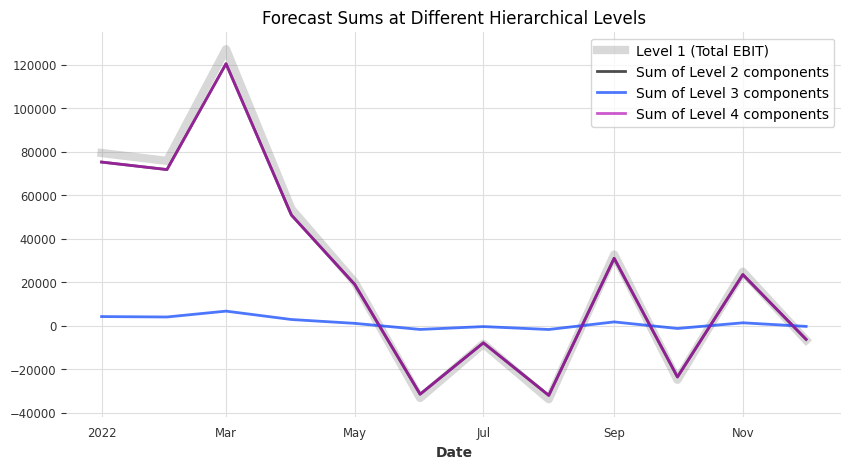

In [ ]:
reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)
measure_mae(reconcilied_preds, val)
plot_forecast_sums(reconcilied_preds)

mean MAE on Level 1 (Top-Level: EBIT): 24953.47
mean MAE on Level 2 Components): 8287.28
mean MAE on Level 3 Components): 5940.98
mean MAE on Level 4 Components): 5940.98


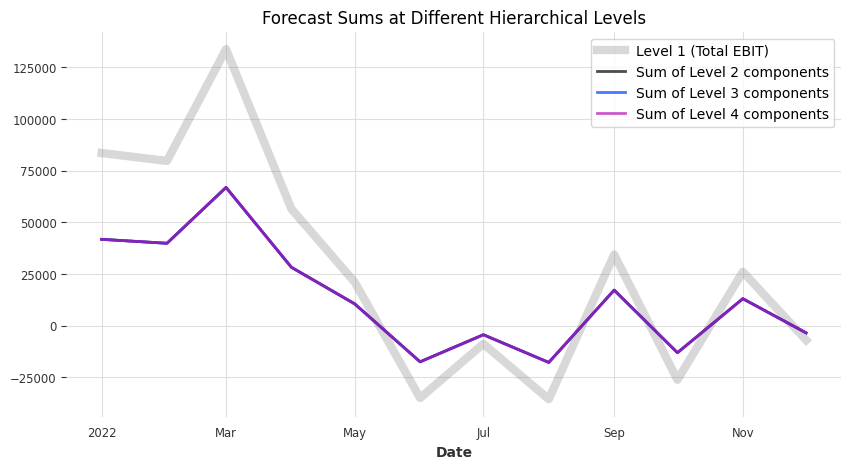

In [ ]:
reconciliator1 = BottomUpReconciliator()
reconcilied1_preds = reconciliator1.transform(pred)
measure_mae(reconcilied1_preds, val)
plot_forecast_sums(reconcilied1_preds)

mean MAE on Level 1 (Top-Level: EBIT): 24953.47
mean MAE on Level 2 Components): 78341.09
mean MAE on Level 3 Components): 13993.38
mean MAE on Level 4 Components): 13993.38


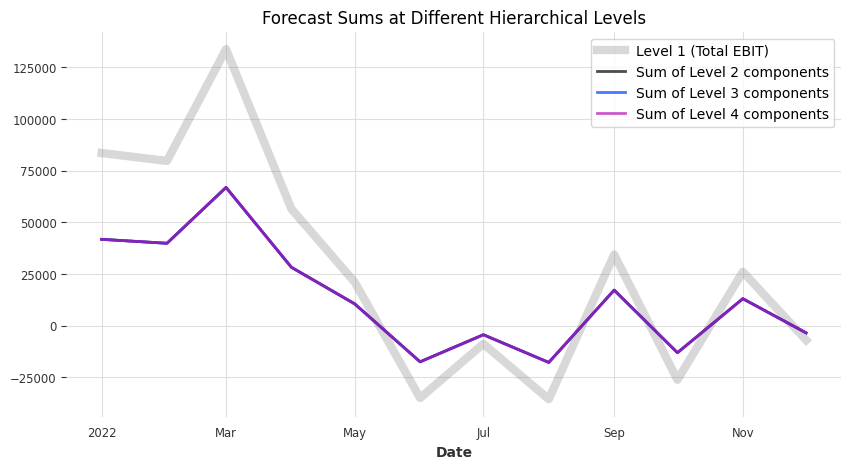

In [ ]:
reconciliator2 = TopDownReconciliator()
reconciliator2.fit(train)
reconcilied2_preds = reconciliator2.transform(pred)
measure_mae(reconcilied2_preds, val)
plot_forecast_sums(reconcilied2_preds)

In [ ]:
def measure_mae(pred, val):
    def print_mae_on_subset(subset, name):
        mae_value = mae(pred[subset], val[subset])
        print(f"mean MAE on {name}: {mae_value:.2f}")

    # Measure MAE at each hierarchical level
    print_mae_on_subset(level_1, "Level 1 (Top-Level: EBIT)")
    print_mae_on_subset(level_2, "Level 2 Components)")
    print_mae_on_subset(level_3, "Level 3 Components)")
    print_mae_on_subset(level_3, "Level 4 Components)")

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error, r2_score
import numpy as np

# Define function to measure multiple metrics
def measure_metrics(pred, val):
    def print_metrics_on_subset(subset, name):
        mae_value = mae(pred[subset], val[subset])
        rmse_value = np.sqrt(mean_squared_error(pred[subset], val[subset]))
        r2_value = r2_score(val[subset], pred[subset])
        mape_value = np.mean(np.abs((val[subset] - pred[subset]) / val[subset])) * 100

        print(f"Metrics for {name}:")
        print(f" - MAE: {mae_value:.2f}")
        print(f" - RMSE: {rmse_value:.2f}")
        print(f" - R² Score: {r2_value:.2f}")
        print(f" - MAPE: {mape_value:.2f}%\n")

    # Measure metrics at each hierarchical level
    print_metrics_on_subset(level_1, "Level 1 (Top-Level: EBIT)")
    print_metrics_on_subset(level_2, "Level 2 Components")
    print_metrics_on_subset(level_3, "Level 3 Components")
    print_metrics_on_subset(level_4, "Level 4 Components")


measure_metrics(reconcilied1_preds, val)
plot_forecast_sums(reconcilied1_preds)

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

Accessing subset: Level 1 (Top-Level: EBIT), Type: <class 'list'>
Error computing metrics for Level 1 (Top-Level: EBIT): 'method' object is not subscriptable
Accessing subset: Level 2 Components, Type: <class 'list'>
Error computing metrics for Level 2 Components: 'method' object is not subscriptable
Accessing subset: Level 3 Components, Type: <class 'list'>
Error computing metrics for Level 3 Components: 'method' object is not subscriptable
Accessing subset: Level 4 Components, Type: <class 'list'>
Error computing metrics for Level 4 Components: 'method' object is not subscriptable


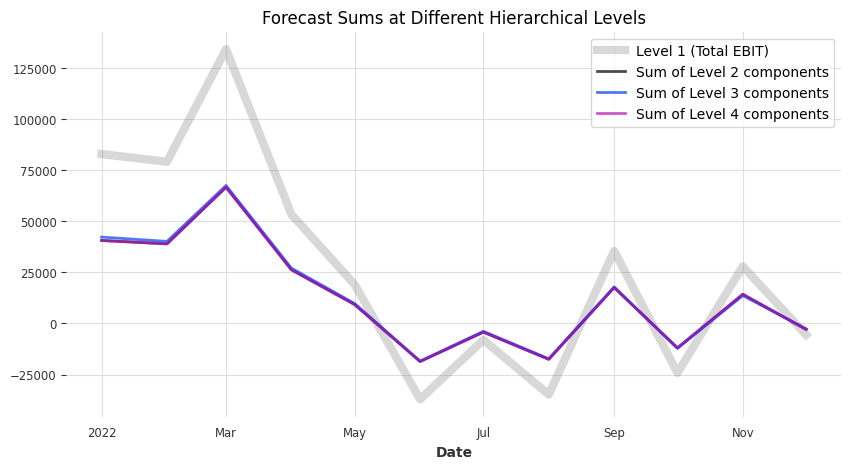

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Function to compute all metrics safely
def measure_metrics(pred, val):
    def safe_convert(timeseries_obj):
        """Ensure the input is a NumPy array before indexing."""
        if hasattr(timeseries_obj, "values"):  # Check if it's a TimeSeries object
            return timeseries_obj.values  # Convert TimeSeries to NumPy array
        elif isinstance(timeseries_obj, pd.Series):
            return timeseries_obj.to_numpy()  # Convert Pandas Series to NumPy
        elif isinstance(timeseries_obj, np.ndarray):
            return timeseries_obj  # Already a NumPy array
        else:
            raise TypeError(f"Unsupported type: {type(timeseries_obj)}")

    # Fully convert `pred` and `val` **before** indexing
    pred_array = safe_convert(pred)
    val_array = safe_convert(val)

    def print_metrics_on_subset(subset_indices, name):
        try:
            print(f"Accessing subset: {name}, Type: {type(subset_indices)}")

            # Extract subset using index list
            pred_subset = pred_array[:, subset_indices, 0]  # Remove last dimension (if shape is (12,7,1))
            val_subset = val_array[:, subset_indices, 0]

            print(f"Subset shape: Pred {pred_subset.shape}, Val {val_subset.shape}")

            if pred_subset.shape != val_subset.shape:
                print(f"Warning: Shape mismatch for {name} (Pred: {pred_subset.shape}, Val: {val_subset.shape})")
                return

            mae_value = mae(pred_subset, val_subset)
            rmse_value = np.sqrt(mean_squared_error(pred_subset, val_subset))
            r2_value = r2_score(val_subset, pred_subset)
            mape_value = np.mean(np.abs((val_subset - pred_subset) / (val_subset + 1e-10))) * 100  # Avoid div by zero

            print(f"Metrics for {name}:")
            print(f" - MAE: {mae_value:.2f}")
            print(f" - RMSE: {rmse_value:.2f}")
            print(f" - R² Score: {r2_value:.2f}")
            print(f" - MAPE: {mape_value:.2f}%\n")

        except Exception as e:
            print(f"Error computing metrics for {name}: {e}")

    # Measure metrics at each hierarchical level
    print_metrics_on_subset(level_1, "Level 1 (Top-Level: EBIT)")
    print_metrics_on_subset(level_2, "Level 2 Components")
    print_metrics_on_subset(level_3, "Level 3 Components")
    print_metrics_on_subset(level_4, "Level 4 Components")

# Run the function
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

reconciliator1 = BottomUpReconciliator()
reconcilied1_preds = reconciliator1.transform(pred)

measure_metrics(reconcilied1_preds, val)
plot_forecast_sums(reconcilied1_preds)



In [ ]:
reconcilied1_preds

<TimeSeries (DataArray) (Date: 12, component: 7, sample: 1)> Size: 672B
array([[[  82886.55377646],
        [  53275.99899909],
        [ -11008.72211086],
        [ 102590.08348274],
        [ -61970.80659451],
        [ 176599.82698998],
        [ -74009.74350724]],

       [[  79118.55377646],
        [  52251.99899909],
        [ -12088.72211086],
        [ 112830.08348274],
        [ -73874.80659451],
        [ 196055.82698998],
        [ -83225.74350724]],

       [[ 134174.55377646],
        [  79387.99899909],
        [ -11880.72211086],
        [ 138942.08348274],
...
        [  80062.08348274],
        [ -92034.80659451],
        [ 133079.82698998],
        [ -53017.74350724]],

       [[  27942.55377646],
        [  27291.99899909],
        [ -13632.72211086],
        [  97982.08348274],
        [ -83698.80659451],
        [ 163543.82698998],
        [ -65561.74350724]],

       [[  -5517.44622354],
        [  11035.99899909],
        [ -13652.72211086],
        [  93694.08348274],
        [ -96594.80659451],
        [ 134231.82698998],
        [ -40537.74350724]]])
Coordinates:
  * Date       (Date) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
  * component  (component) object 56B 'EBIT' 'EBITDA' ... '-VariableCosts'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          {'EBITDA': ['EBIT'], '-DepreciationAmortization': ['E...

In [ ]:
# Convert TimeSeries to NumPy arrays and remove the last dimension
pred_array = reconcilied1_preds.values.squeeze()  # Shape: (12, 7)
val_array = val.values.squeeze()                  # Shape: (12, 7)

# Verify the shapes
print(f"Shape of Predictions Array: {pred_array.shape}")
print(f"Shape of Actual Values Array: {val_array.shape}")

AttributeError: 'function' object has no attribute 'squeeze'

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Convert TimeSeries to NumPy arrays and remove the singleton 'sample' dimension
pred_array = reconcilied1_preds.values.squeeze()  # Shape: (12, 7)
val_array = val.values.squeeze()                # Shape: (12, 7)

# Verify the shapes
print(f"Shape of Predictions Array: {pred_array.shape}")
print(f"Shape of Actual Values Array: {val_array.shape}")

# Step 2: Retrieve component names
components = reconcilied1_preds.components
print("Components:", components)

# Step 3: Define hierarchical levels manually based on your hierarchy
levels = [
    (['EBIT'], "Level 1 (Top-Level: EBIT)"),
    (['EBITDA', '-DepreciationAmortization', '-FixCosts'], "Level 2 Components"),
    (['ContributionMargin1', 'NetSales'], "Level 3 Components"),
    (['-VariableCosts'], "Level 4 Components")
]

# Convert component names to indices using .get_loc()
levels_with_indices = []
for subset_names, level_name in levels:
    subset_indices = []
    for comp in subset_names:
        if comp in components:
            subset_indices.append(components.get_loc(comp))
        else:
            print(f"Warning: Component '{comp}' not found for {level_name}.")
    if subset_indices:
        levels_with_indices.append((subset_indices, level_name))

# Step 4: Define the measure_metrics function
def measure_metrics(pred_array, val_array, components, levels):
    """
    Computes and prints MAE, MAPE, R², and RMSE for each hierarchical level.

    Parameters:
    - pred_array (np.ndarray): Predicted values, shape (time_steps, components)
    - val_array (np.ndarray): Actual values, shape (time_steps, components)
    - components (pd.Index): List of component names
    - levels (list of tuples): Each tuple contains a list of component indices and a level name
    """
    for subset_indices, level_name in levels:
        try:
            # Extract subsets
            pred_subset = pred_array[:, subset_indices]
            val_subset = val_array[:, subset_indices]

            # Compute Metrics
            mae_val = mean_absolute_error(val_subset, pred_subset)
            rmse_val = np.sqrt(mean_squared_error(val_subset, pred_subset))
            r2_val = r2_score(val_subset, pred_subset, multioutput='uniform_average')
            mape_val = np.mean(np.abs((val_subset - pred_subset) / (val_subset + 1e-10))) * 100  # Avoid division by zero

            # Retrieve component names
            subset_names = [components[i] for i in subset_indices]

            # Print Metrics
            print(f"Metrics for {level_name} ({', '.join(subset_names)}):")
            print(f" - MAE: {mae_val:.2f}")
            print(f" - RMSE: {rmse_val:.2f}")
            print(f" - R² Score: {r2_val:.2f}")
            print(f" - MAPE: {mape_val:.2f}%\n")

        except Exception as e:
            print(f"Error computing metrics for {level_name}: {e}")

# Step 5: Call the measure_metrics function
measure_metrics(pred_array, val_array, components, levels_with_indices)

AttributeError: 'function' object has no attribute 'squeeze'

#### Backtesting

In [ ]:
# Load the data from an Excel file
file_path = '/content/SampleHierForecastingBASF_share.xlsx'  # Path to your Excel file
df = pd.read_excel(file_path)  # Specify the sheet name or index if needed

# Display the first few rows to verify
print("Data Preview:\n", df.head())

Data Preview:
         Date      NetSales  VariableCosts  ContributionMargin1      FixCosts  \
0 2008-01-01  46395.562988   11530.938420         34864.624569  28085.056839   
1 2008-02-01  71258.917420   23005.990813         48252.926607  25574.419442   
2 2008-03-01  82672.156481   33251.338936         49420.817545  23989.711891   
3 2008-04-01  91239.441986   33569.084866         57670.357120  26096.657423   
4 2008-05-01  76852.388916   31133.385550         45719.003366  23010.859671   

           EBIT  DepreciationAmortization        EBITDA  
0   6779.567730               3913.291983  10692.859713  
1  22678.507166               2656.703148  25335.210314  
2  25431.105654               3308.918478  28740.024133  
3  31573.699697               4013.632803  35587.332501  
4  22708.143695               3241.601219  25949.744914  


In [ ]:
def plot_backtests(series, forecast_horizon=6):
    """
    Function to plot backtests and forecast results for different models.

    Parameters:
    - series: TimeSeries data
    - forecast_horizon: The forecast horizon in months (1, 3, 6, 12)
    """
    plt.figure(figsize=(10, 6))

    # Define models to use for forecasting
    models = [ExponentialSmoothing(), Prophet()]

    # Perform backtests for each model
    backtests = [model.historical_forecasts(series['EBIT'], start=0.5, forecast_horizon=forecast_horizon) for model in models]

    # Plot actual data
    series['EBIT'].plot(label='Actual Data')

    # Loop over each model to plot the backtest and print metrics
    for i, m in enumerate(models):
        # Plot the backtest forecast (only for forecast horizon)
        backtest = backtests[i]
        backtest.plot(lw=1, label=f'{m} Forecast')

        # Get the actual values from the series for the forecast horizon
        actual_values = series['EBIT'][-forecast_horizon:]

        # Print metrics using the get_metrics function
        get_metrics(backtest, actual_values, f'{m}')

    plt.title(f'Backtests with {forecast_horizon}-months forecast horizon')
    plt.legend()
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/d0ulpzl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/6nxilj6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12640', 'data', 'file=/tmp/tmpl_hj92ft/d0ulpzl8.json', 'init=/tmp/tmpl_hj92ft/6nxilj6n.json', 'output', 'file=/tmp/tmpl_hj92ft/prophet_modelqh7q670u/prophet_model-20250313094951.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:49:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

MAE for ExponentialSmoothing(): 2206.43
MAPE for ExponentialSmoothing(): 39.56
RMSE for ExponentialSmoothing(): 2492.29


ValueError: Found input variables with inconsistent numbers of samples: [6, 92]

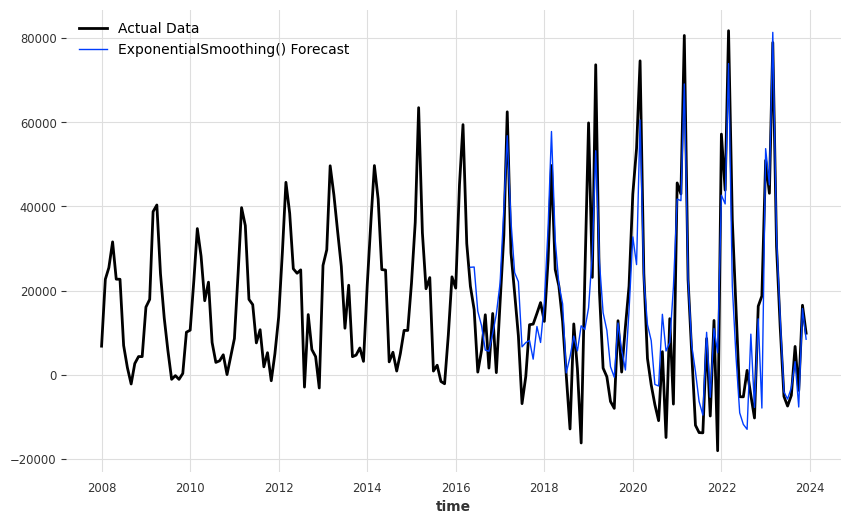

In [ ]:
# Example usage:
plot_backtests(series, forecast_horizon=6)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/675cu697.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/kagjfn_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83651', 'data', 'file=/tmp/tmpl_hj92ft/675cu697.json', 'init=/tmp/tmpl_hj92ft/kagjfn_m.json', 'output', 'file=/tmp/tmpl_hj92ft/prophet_modelg2qmk71v/prophet_model-20250313094650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

MAE for ExponentialSmoothing(): 8281.74
MAPE for ExponentialSmoothing(): 200.90
RMSE for ExponentialSmoothing(): 11147.75


ValueError: Found input variables with inconsistent numbers of samples: [192, 92]

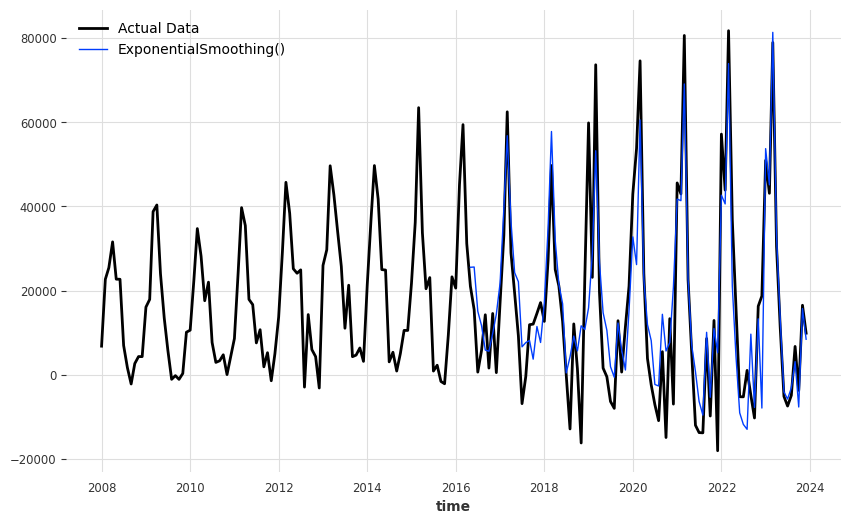

In [ ]:
plot_backtests(series, forecast_horizon=3)

In [ ]:
# Function to compute RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Plot the backtests and forecast results
plt.figure(figsize=(10, 6))

models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=0.5, forecast_horizon=6) for model in models]

# Plot the actual data
series['EBIT'].plot(label='Actual Data')

# Loop over each model to plot the backtest and print the metrics
for i, m in enumerate(models):
    # Get the backtest forecast
    forecast = backtests[i]

    # Compute the metrics
    err_mape = np.mean(np.abs((forecast - series['EBIT'][-6:]) / series['EBIT'][-6:])) * 100  # MAPE
    err_mae = mae(series['EBIT'][-6:], forecast)  # MAE
    err_r2 = r2_score(series['EBIT'][-6:], forecast)  # R²
    err_rmse = rmse(series['EBIT'][-6:], forecast)  # RMSE

    # Print the metrics separately
    print(f"Model {m}:")
    print(f"MAPE: {err_mape:.2f}%")
    print(f"MAE: {err_mae:.2f}")
    print(f"RMSE: {err_rmse:.2f}")
    print(f"R²: {err_r2:.2f}")
    print("-" * 50)

    # Plot the backtest forecast
    forecast.plot(lw=1, label=f'{m} Forecast')

# Set plot title and legend
plt.title('Backtests with 6-months forecast horizon')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=6) for model in models]

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err_mape = mape(backtests[i], series['EBIT'])
    err_mae = mae(backtests[i], series['EBIT'])
    err_r2 = r2_score(backtests[i], series['EBIT'])
    err_rmse = rmse(backtests[i], series['EBIT'])

    backtests[i].plot(
        lw=1,
        label='{}, MAPE={:.2f}%, MAE={:.2f}, R²={:.2f}, RMSE={:.2f}'.format(
            m, err_mape, err_mae, err_r2, err_rmse
        )
    )

plt.title('Backtests with 6-months forecast horizon')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-130-b84a191f4680>", line 3, in <cell line: 0>
    backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=6) for model in models]
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-130-b84a191f4680>", line 3, in <listcomp>
    backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=6) for model in models]
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/darts/utils/utils.py", line 259, in sanitized_method
    return method_to_sanitize(self, *only_args.values(), **only_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

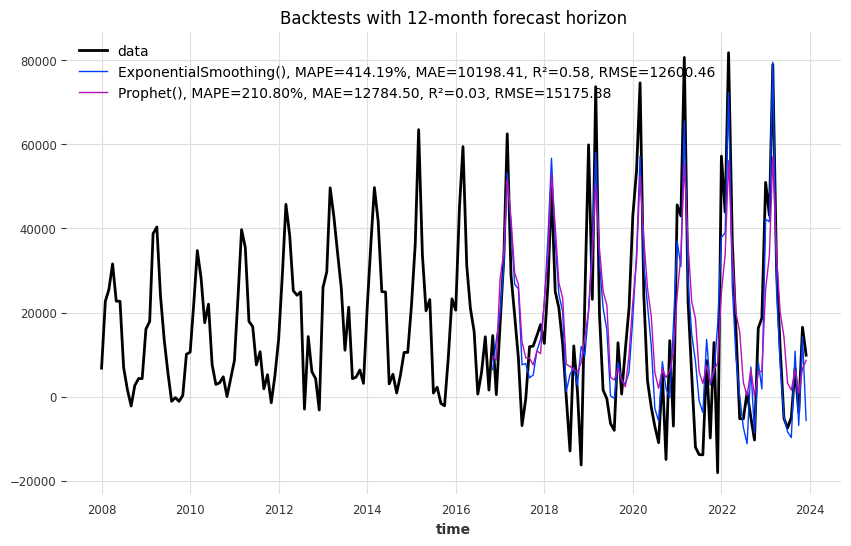

In [ ]:
from darts.metrics import mape, mae, r2_score, rmse
import matplotlib.pyplot as plt
from darts.models import Prophet


plt.figure(figsize=(10, 6))
models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=12) for model in models]

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err_mape = mape(backtests[i], series['EBIT'])
    err_mae = mae(backtests[i], series['EBIT'])
    err_r2 = r2_score(backtests[i], series['EBIT'])
    err_rmse = rmse(backtests[i], series['EBIT'])

    backtests[i].plot(
        lw=1,
        label='{}, MAPE={:.2f}%, MAE={:.2f}, R²={:.2f}, RMSE={:.2f}'.format(
            m, err_mape, err_mae, err_r2, err_rmse
        )
    )

plt.title('Backtests with 12-month forecast horizon')
plt.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/rob8s5fl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_hj92ft/9349ilej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29561', 'data', 'file=/tmp/tmpl_hj92ft/rob8s5fl.json', 'init=/tmp/tmpl_hj92ft/9349ilej.json', 'output', 'file=/tmp/tmpl_hj92ft/prophet_model32xlss43/prophet_model-20250313100153.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

NameError: name 'np' is not defined

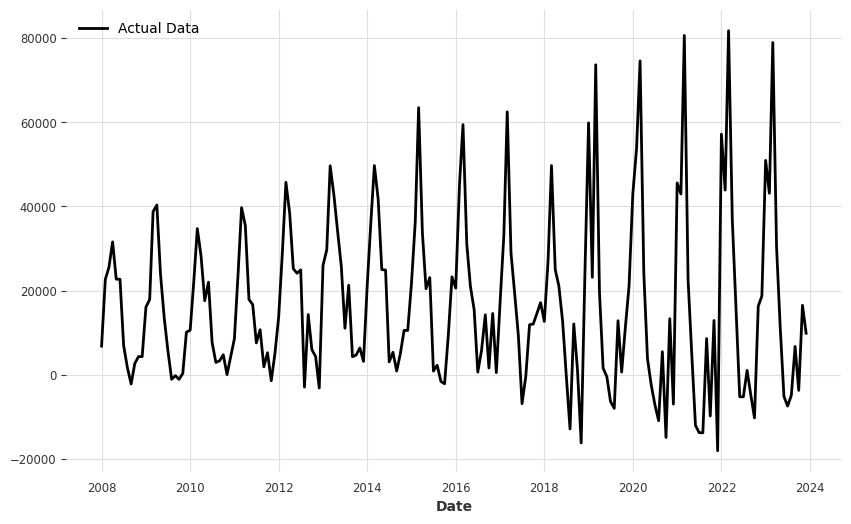

In [ ]:
# Function to compute RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Function to evaluate and plot forecasts for different forecast horizons
def evaluate_models_with_horizons(series, horizons=[1, 3, 6, 12]):
    # Store metrics for each horizon
    all_metrics = []

    plt.figure(figsize=(10, 6))

    models = [ExponentialSmoothing(), Prophet()]

    for horizon in horizons:
        backtests = [model.historical_forecasts(series['EBIT'], start=0.5, forecast_horizon=horizon) for model in models]

        # Plot the actual data
        series['EBIT'].plot(label='Actual Data')

        # Loop over each model to plot the backtest and print the metrics
        for i, m in enumerate(models):
            # Get the backtest forecast
            forecast = backtests[i]

            # Compute the metrics for each horizon
            err_mape = np.mean(np.abs((forecast - series['EBIT'][-horizon:]) / series['EBIT'][-horizon:])) * 100  # MAPE
            err_mae = mae(series['EBIT'][-horizon:], forecast)  # MAE
            err_r2 = r2_score(series['EBIT'][-horizon:], forecast)  # R²
            err_rmse = rmse(series['EBIT'][-horizon:], forecast)  # RMSE

            # Print the metrics for the current horizon
            print(f"Model {m}, Horizon {horizon} months:")
            print(f"MAPE: {err_mape:.2f}%")
            print(f"MAE: {err_mae:.2f}")
            print(f"RMSE: {err_rmse:.2f}")
            print(f"R²: {err_r2:.2f}")
            print("-" * 50)

            # Plot the backtest forecast for the current horizon
            forecast.plot(lw=1, label=f'{m} Horizon={horizon} months')

        # Set plot title and legend for each horizon
        plt.title(f'Backtests with {horizon}-months forecast horizon')
        plt.legend()
        plt.show()

        # Store metrics in a list for external table
        all_metrics.append({
            'Horizon': horizon,
            'MAPE': err_mape,
            'MAE': err_mae,
            'RMSE': err_rmse,
            'R²': err_r2
        })

    # Convert the metrics list to a DataFrame for an external table
    import pandas as pd
    metrics_df = pd.DataFrame(all_metrics)

    # Display the performance table
    print("\nPerformance Metrics Table:")
    print(metrics_df)


# Call the function with different forecast horizons
evaluate_models_with_horizons(series, horizons=[1, 3, 6, 12])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

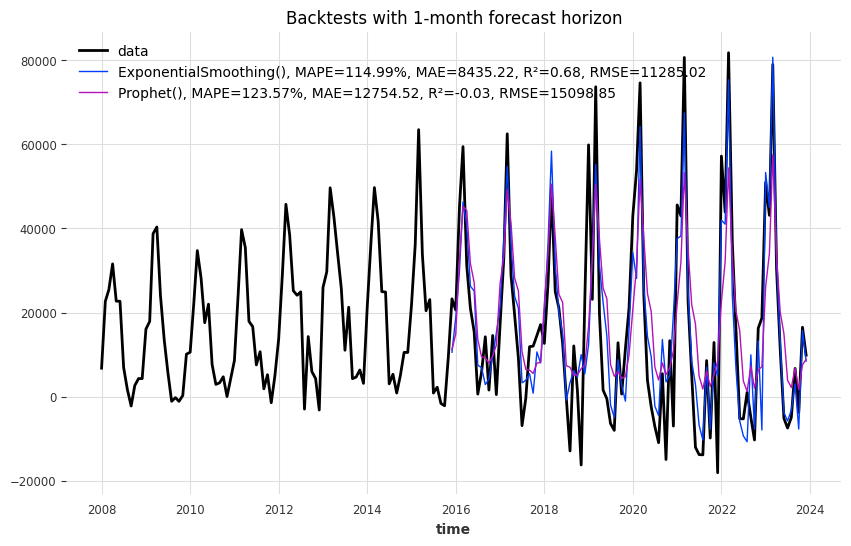

In [ ]:
from darts.metrics import mape, mae, r2_score, rmse
import matplotlib.pyplot as plt
from darts.models import Prophet


plt.figure(figsize=(10, 6))
models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=1) for model in models]

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err_mape = mape(backtests[i], series['EBIT'])
    err_mae = mae(backtests[i], series['EBIT'])
    err_r2 = r2_score(backtests[i], series['EBIT'])
    err_rmse = rmse(backtests[i], series['EBIT'])

    backtests[i].plot(
        lw=1,
        label='{}, MAPE={:.2f}%, MAE={:.2f}, R²={:.2f}, RMSE={:.2f}'.format(
            m, err_mape, err_mae, err_r2, err_rmse
        )
    )

plt.title('Backtests with 1-month forecast horizon')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

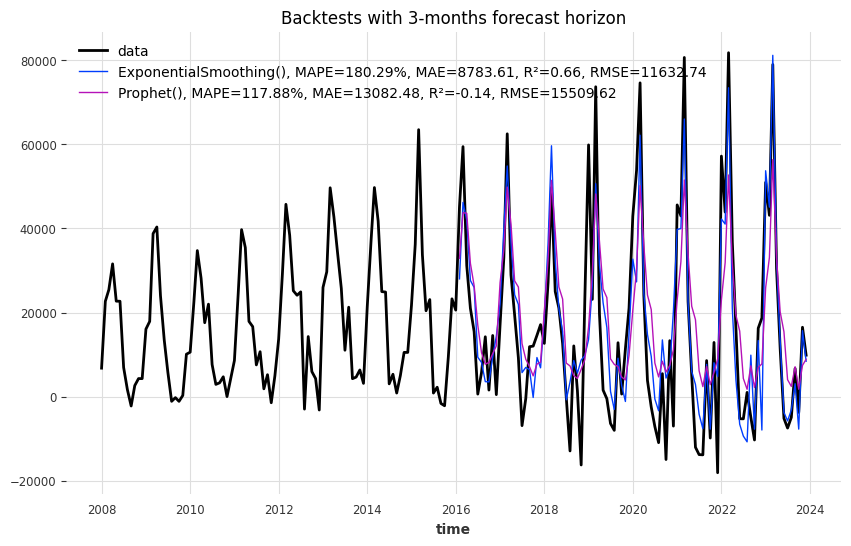

In [ ]:
from darts.metrics import mape, mae, r2_score, rmse
import matplotlib.pyplot as plt
from darts.models import Prophet


plt.figure(figsize=(10, 6))
models = [ExponentialSmoothing(), Prophet()]
backtests = [model.historical_forecasts(series['EBIT'], start=.5, forecast_horizon=3) for model in models]

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err_mape = mape(backtests[i], series['EBIT'])
    err_mae = mae(backtests[i], series['EBIT'])
    err_r2 = r2_score(backtests[i], series['EBIT'])
    err_rmse = rmse(backtests[i], series['EBIT'])

    backtests[i].plot(
        lw=1,
        label='{}, MAPE={:.2f}%, MAE={:.2f}, R²={:.2f}, RMSE={:.2f}'.format(
            m, err_mape, err_mae, err_r2, err_rmse
        )
    )

plt.title('Backtests with 3-months forecast horizon')
plt.legend()
plt.show()

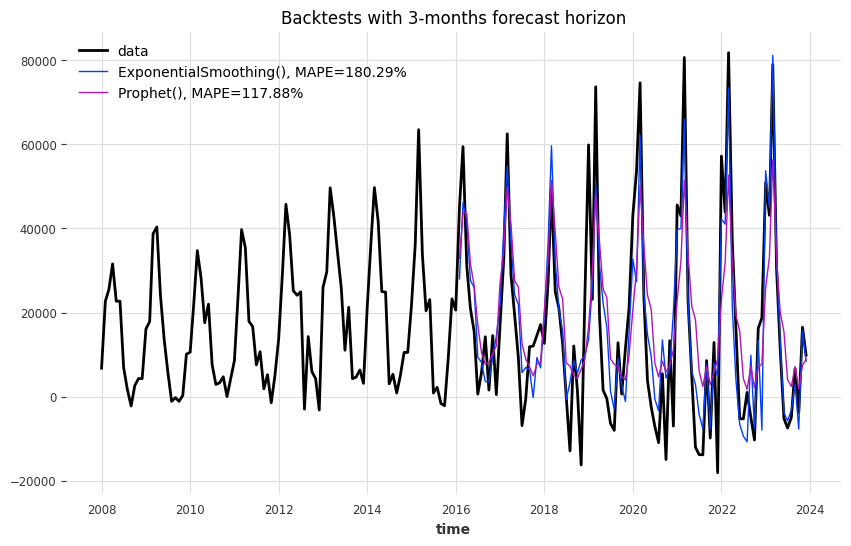

In [ ]:
from darts.metrics import mape

plt.figure(figsize=(10, 6))

series['EBIT'].plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series['EBIT'])
    backtests[i].plot(lw=1, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()